# Wine Recommender System - Exploratory Data Analysis

### Project Goal: 

This project uses a Kaggle database of over 129,000 wine reviews from Wine Enthusiast/Wine Magazine. The data contains information related to variety, price, rating, and tasting notes. My desired outcome is to create a wine recommender that, when a user inputs a wine name, it will recommend a similar wine. The similarity will be based on variety, tasting notes, and price. 

### What's in This Notebook
In this notebook, I conduct some preliminary natural language processing (NLP) in which I use Count Vectoraization to identify the most common words used in the tasting note "description." I also use CVEC, Term-Frequency Inverse Document Frequency and Logistic Regression to as well as create a model to predict the wine varietal, Chardonnay.

While CVEC counts the most frequent words, TF-IDF will downweight the most frequent words to get the "bigger picture", so it's good to see both methods in action. 

In [1]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from os import path

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text 

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict, cross_val_score
from sklearn.metrics import confusion_matrix

In [3]:
df = pd.read_csv('./datasets/wine.csv')

In [4]:
df.shape

(73691, 15)

## Fun with WordClouds!

As a fun introduction to this workbook, I created a wordclouds for California Chardonnarys and California Cabernets. 

This exercise is actually useful for transitioning to the next part in the recommender project, which will be digging into the descriptions and trying to find common words. 

To begin, I isolate descriptions for California Chardonnays and California Cabernets and save them as separate .csv files, which I load here. 

In [6]:
CAChards = pd.read_csv('./datasets/CAChards.csv')

In [7]:
CACabs = pd.read_csv('./datasets/CACabs.csv')

When I first ran the wordclouds, the most common word was "WINE" and "FLAVOR", which was not helpful, so I made those stopwords, in addition to the variety names. 

In [8]:
stopwords = set(STOPWORDS)
stopwords.add("wine")
stopwords.add("flavor")
stopwords.add("flavors")
stopwords.add("chardonnay")
stopwords.add("cab")
stopwords.add("cabernet")

In [9]:
wordcloud = WordCloud(stopwords = stopwords).generate(' '.join(CAChards['Description']))
wordcloud2 = WordCloud(stopwords=stopwords).generate(' '.join(CACabs['description']))

#### California Chardonnay Wordcloud

The most used words I'm seeing are pineapple, buttered toast, fruit, green apple, rich. I see a "chard" in there, so should probably include that as a stop word in a later interation. 

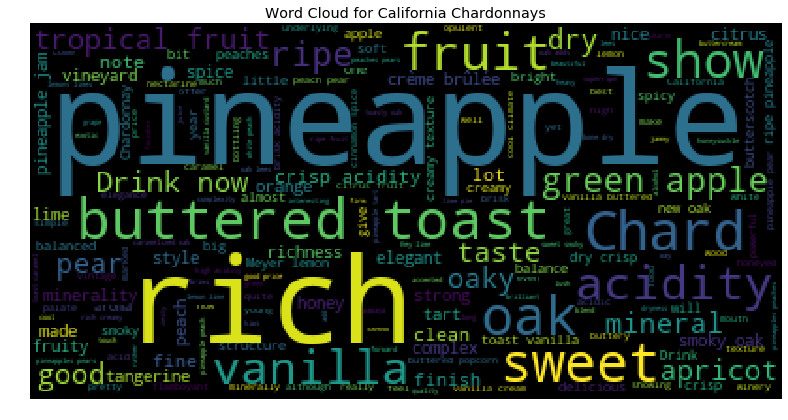

In [10]:
plt.figure(figsize=(12,9))
plt.title("Word Cloud for California Chardonnays")
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

#### California Cabernet Wordcloud

By contrast, the most common words I see for cabernets are tannin, black currant, oak, dry, and also fruit and rich, which were also found above. 

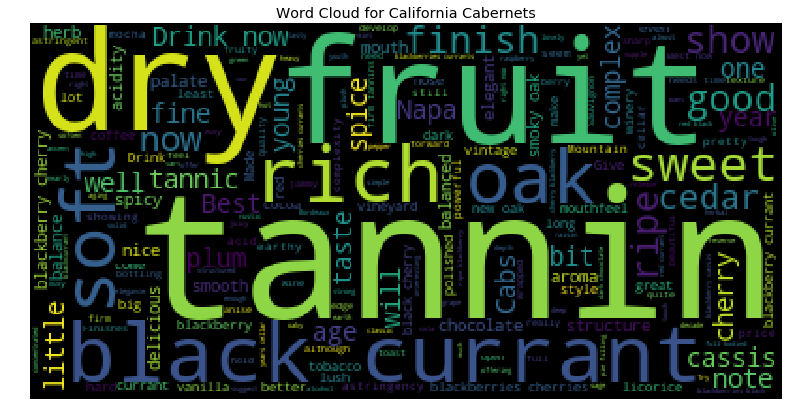

In [11]:
plt.figure(figsize=(12,9))
plt.title("Word Cloud for California Cabernets")
plt.imshow(wordcloud2)
plt.axis("off")
plt.show()

## Natural Language Processing

Okay, enough of the pretty pictures. In this section, I use NLP tools of Count Vectorization and TF-IDF to explore the description variable. 

For Count Vectorization, I'll take a sample of the 70,000 rows so as not to crash my kernel! 

In [25]:
from random import sample
sample_text = df['description'].sample(1500)

In [23]:
my_additional_stop_words = ['wine', 'flavor', 'flavors']
stop_words = text.ENGLISH_STOP_WORDS.union(my_additional_stop_words)

This code fits and transforms the sample text and gives the most common words in the sample of descriptions. Fruit, aromas, black, palate, tannis, finish, etc. are used quite commonly. 

In [24]:
cvec = CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict', encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 3), stop_words=stop_words, token_pattern=u'(?u)\\b\\w\\w+\\b')

cvec.fit(sample_text)

new_df  = pd.DataFrame(cvec.transform(sample_text).todense(),
             columns=cvec.get_feature_names()).sum(axis=0)

most_common_words = new_df.transpose().sort_values(0, ascending=False).transpose()
most_common_words.head(20)

fruit      605
aromas     424
palate     410
finish     406
drink      390
tannins    387
acidity    383
black      372
cherry     370
ripe       300
red        242
notes      230
spice      227
oak        218
dry        213
nose       189
berry      184
plum       184
rich       181
fresh      179
dtype: int64

### Predicting the Chardonnay varietal from the descriptions

In [33]:
df['Chard'] = df['variety'] == "Chardonnay"

Here I see I have a good many Chardonnays in the dataset to try to predict. 

In [34]:
df['Chard'] = df['Chard'].astype(int)
df['Chard'].value_counts()

0    64441
1     9250
Name: Chard, dtype: int64

In [35]:
def description(df):
    return df['description']

description_tf = FunctionTransformer(description, validate=False)

In [36]:
my_additional_stop_words = ['wine', 'flavor', 'flavors', 'Chardonnay', 'chardonnay', 'chard']
stop_words = text.ENGLISH_STOP_WORDS.union(my_additional_stop_words)

In [37]:
cv = CountVectorizer(stop_words = stop_words)
tf = TfidfVectorizer(stop_words = stop_words)

In [38]:
lr = LogisticRegression()

I created a Pipeline and tried both CVEC and TF-IDF in the model, with similar results. I train-test split the data and use a Grid Search over some parameters (this takes awhile to run!). Min_df refers to ignoring words that appear infrequently (I search over less than 1, 2, and 3%). Max_df refers to ignoring words that appear frequently (I search over words that appear in over 50% or 100% of the cases). I had the model look at 1 and 2 n-grams, so single words and words found together/double words. 

I end up with a very large accuracy score of .95. 

In [39]:
pipe = Pipeline([
    ("description_tf", description_tf),
    ("cv", cv),
#    ("tf", tf),
    ("lr", lr)
])

In [40]:
X = df[['description']]
y = df['Chard']

In [41]:
cross_val_score(pipe, X, y).mean()

0.9482161977926845

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [43]:
params = {
    'cv__stop_words': [None, 'english'],
    'cv__ngram_range': [(1, 2)],
    'cv__max_features': [5000],
    'cv__binary': [True,False],
    'cv__min_df': [1,2,3],
    'cv__max_df': [.5, 1.]
}
gs = GridSearchCV(pipe, param_grid=params)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

0.9525041615401317


{'cv__binary': True,
 'cv__max_df': 0.5,
 'cv__max_features': 5000,
 'cv__min_df': 1,
 'cv__ngram_range': (1, 2),
 'cv__stop_words': 'english'}

In [44]:
gs.score(X_test, y_test)

0.9541877001574119

In [53]:
predictions = cross_val_predict(pipe, X_test, y_test)